# Tutorial on DTM surface area and slope statistics

Import all necessary modules, especially all our surface area related functions inside the name space `sa`.

In [2]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import dblquad
from tqdm import trange

import surface_area as sa

pl.rcParams["figure.dpi"] = 200

We provide two synthetic landscape types. One very smooth and constructed from 2D Gaussian functions, and another more rough and hilly consisting of a superposition of Sine and Cosine functions in 2D:

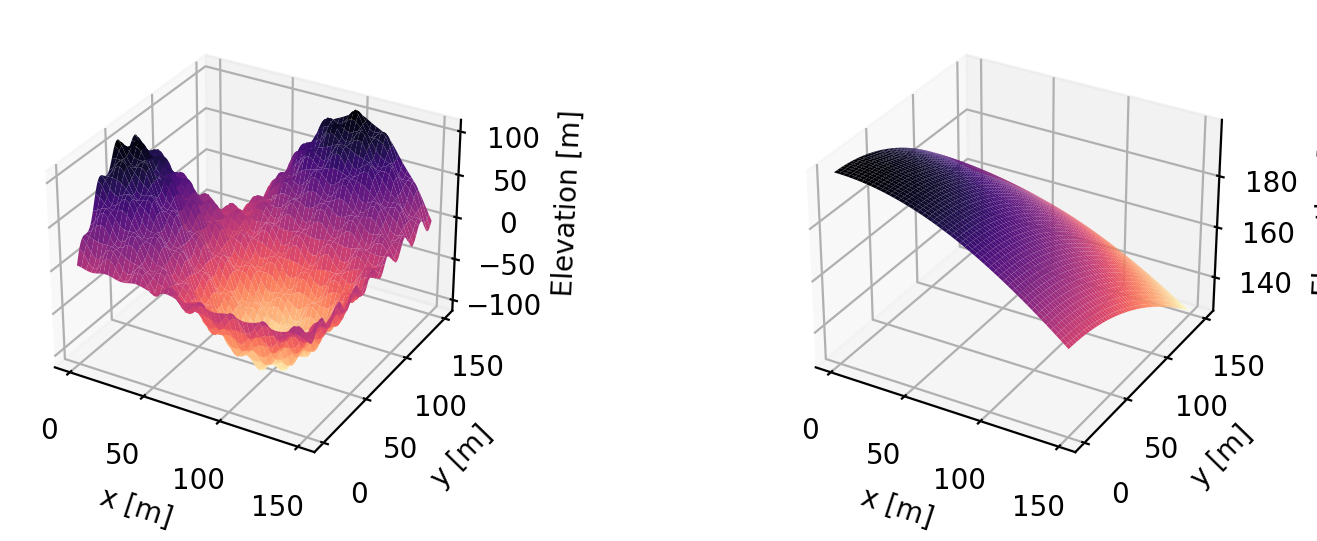

In [51]:
# DTM resolution
resolution = 1
xr = np.arange(resolution / 2, 150, resolution)
yr = xr

# synthetic landscape coordinates
x, y = np.meshgrid(xr, yr)

# Sin Cos DTM
dtm_sincos = sa.synthetic_landscape(x, y, landscape_type="sincos", amplitude=100)

# Gaussian hill DTM
dtm_hill = sa.synthetic_landscape(x, y, landscape_type="hill", amplitude=200)

# visuals
fg, ax = pl.subplots(1, 2, figsize=(9, 3), subplot_kw={"projection": "3d"})
for i, dtm in enumerate((dtm_sincos, dtm_hill)):
    ax[i].plot_surface(x, y, dtm, cmap="magma_r")
    ax[i].set_xlabel("x [m]")
    ax[i].set_ylabel("y [m]")
    ax[i].set_zlabel("Elevation [m]")
pl.show()

For these synthetic landscapes we can also retrieve analytical slopes:

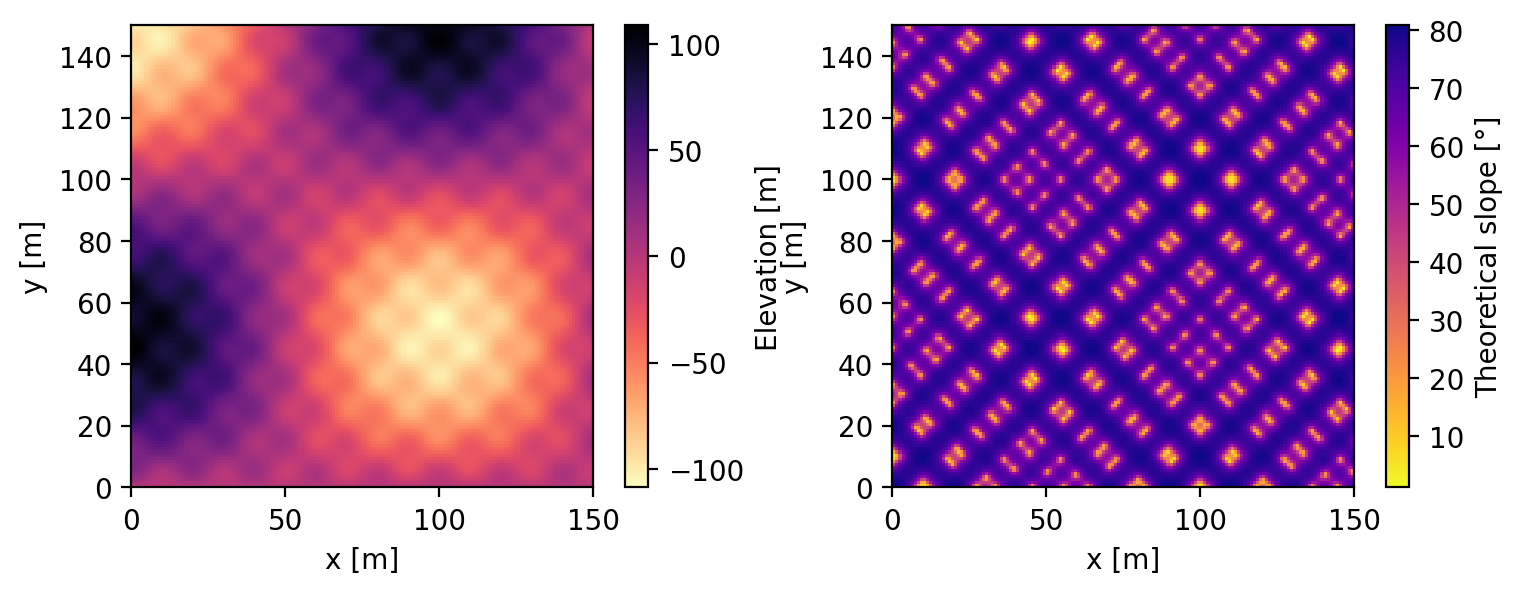

In [3]:
dtm = dtm_sincos

# theoretical slope
slp = (
    180
    / np.pi
    * sa.synthetic_landscape_slope(x, y, landscape_type="sincos", amplitude=100)
)

fg, ax = pl.subplots(1, 2, figsize=(9, 3))
im = ax[0].pcolormesh(x, y, dtm, cmap="magma_r")
ax[0].set_xlabel("x [m]")
ax[0].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[0])
cb.set_label("Elevation [m]")
im = ax[1].pcolormesh(x, y, slp, cmap="plasma_r")
ax[1].set_xlabel("x [m]")
ax[1].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[1])
cb.set_label("Theoretical slope [°]")
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
pl.show()

And we can compare these *true* analytical slopes to those numerically estimated at a given resolution using gradient estimation:

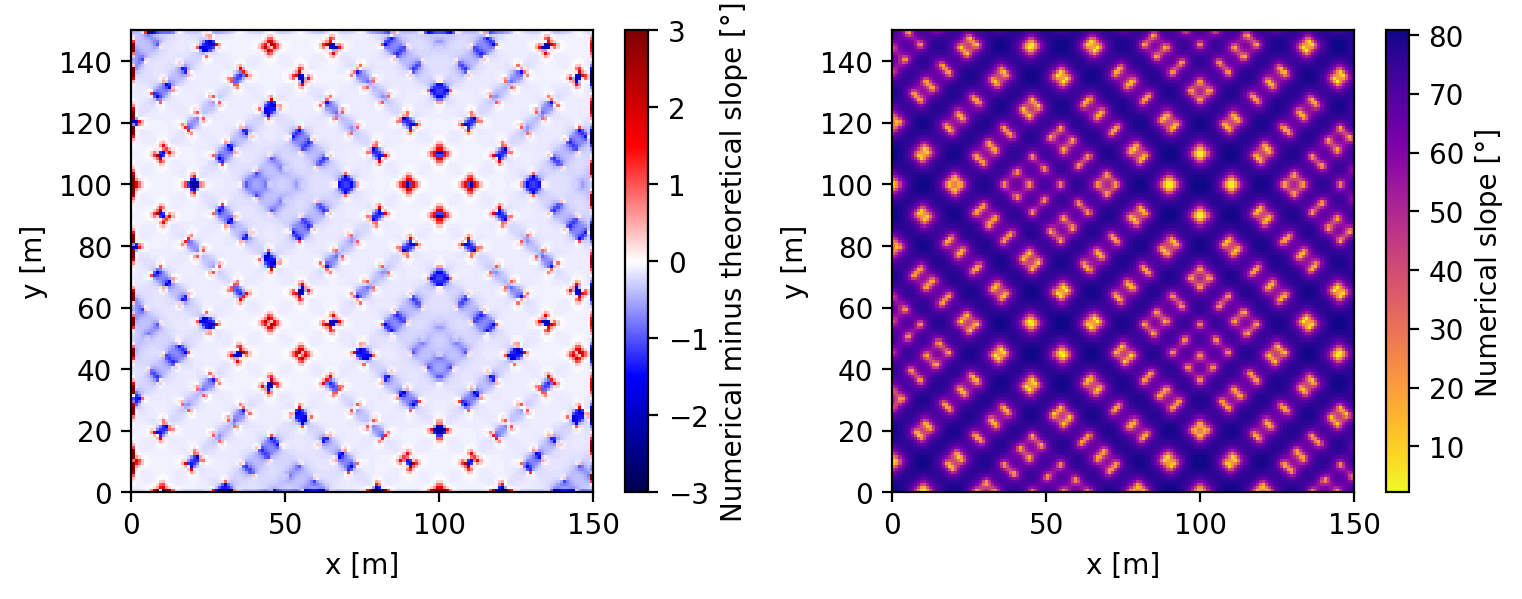

In [4]:
# numerical slope
dy, dx = np.gradient(dtm, resolution)
nslp = 180 / np.pi * np.arctan(np.sqrt(dx * dx + dy * dy))

fg, ax = pl.subplots(1, 2, figsize=(9, 3))
im = ax[0].pcolormesh(x, y, nslp - slp, vmin=-3, vmax=3, cmap="seismic")
ax[0].set_xlabel("x [m]")
ax[0].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[0])
cb.set_label("Numerical minus theoretical slope [°]")
im = ax[1].pcolormesh(x, y, nslp, cmap="plasma_r")
ax[1].set_xlabel("x [m]")
ax[1].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[1])
cb.set_label("Numerical slope [°]")
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
pl.show()

For this landscape errors are largest for small slopes, i.e., for ride crests as well as valley bottoms:

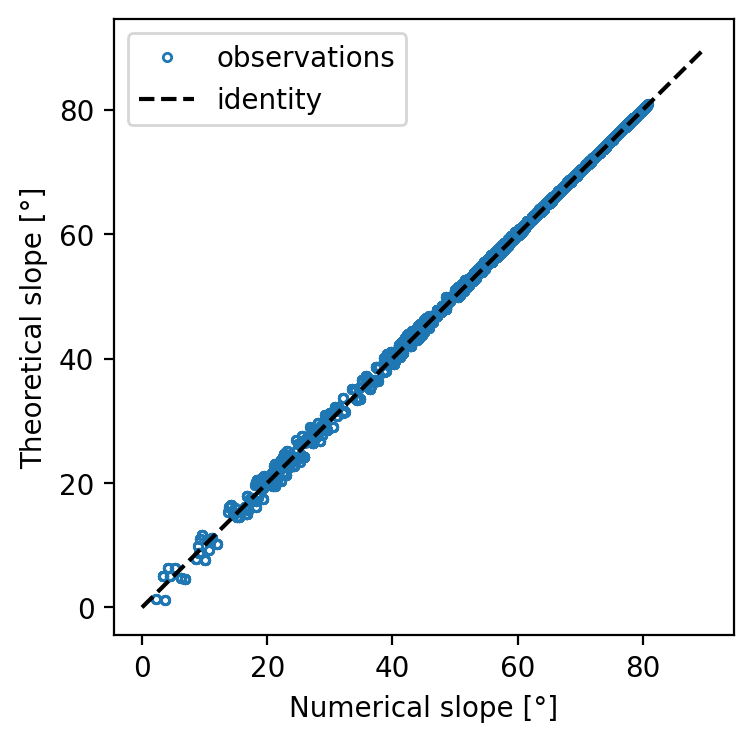

In [5]:
fg, ax = pl.subplots(figsize=(4, 4))
ax.plot(
    nslp[1:-1, 1:-1].ravel(),
    slp[1:-1, 1:-1].ravel(),
    ".",
    mfc="none",
    label="observations",
)
ax.plot([0, 90], [0, 90], "k--", label="identity")
ax.set_xlabel("Numerical slope [°]")
ax.set_ylabel("Theoretical slope [°]")
pl.legend()
pl.show()

We also provide two different approaches to numerical surface area estimation on DTMs. The TIN-based approach by *Jennes et al.*, as well as our COS-based approach:

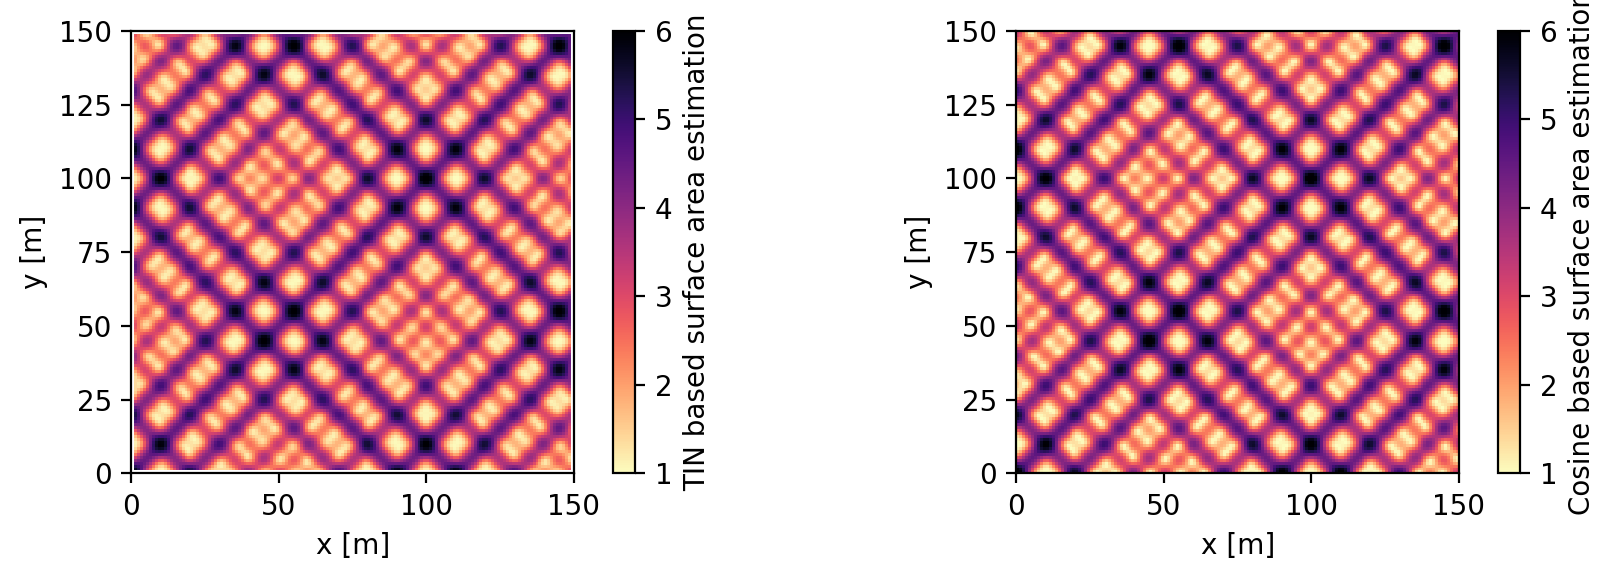

In [6]:
# TIN based surface area according to Jennes et al.
sa_tin = sa.surface_area_tin(dtm, resolution)

# COS based surface area according to our method
sa_cos = sa.surface_area_cos(dtm, resolution)

fg, ax = pl.subplots(1, 2, figsize=(9, 3))
im = ax[0].pcolormesh(x, y, sa_tin, vmin=1, vmax=6, cmap="magma_r")
ax[0].set_xlabel("x [m]")
ax[0].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[0])
cb.set_label("TIN based surface area estimation")
im = ax[1].pcolormesh(x, y, sa_cos, vmin=1, vmax=6, cmap="magma_r")
ax[1].set_xlabel("x [m]")
ax[1].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[1])
cb.set_label("Cosine based surface area estimation")
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
pl.tight_layout()
pl.show()

For synthetic landscapes that have a functional form we can as well numerically compute the *true* surface area of each pixel by numerical integration:

In [7]:
# theoretical surface area using numerical integration
sa_num = sa.synthetic_landscape_surface_area(x, y, landscape_type="sincos", amplitude=100)

100%|███████████████████████████████| 150/150 [01:28<00:00,  1.69it/s]


Our approach (COS) has overall lower error magnitudes and consistently underestimates pixel-wise surface areas. The TIN-based approach does over- as well as underestimates surface areas and has generally larger errors:

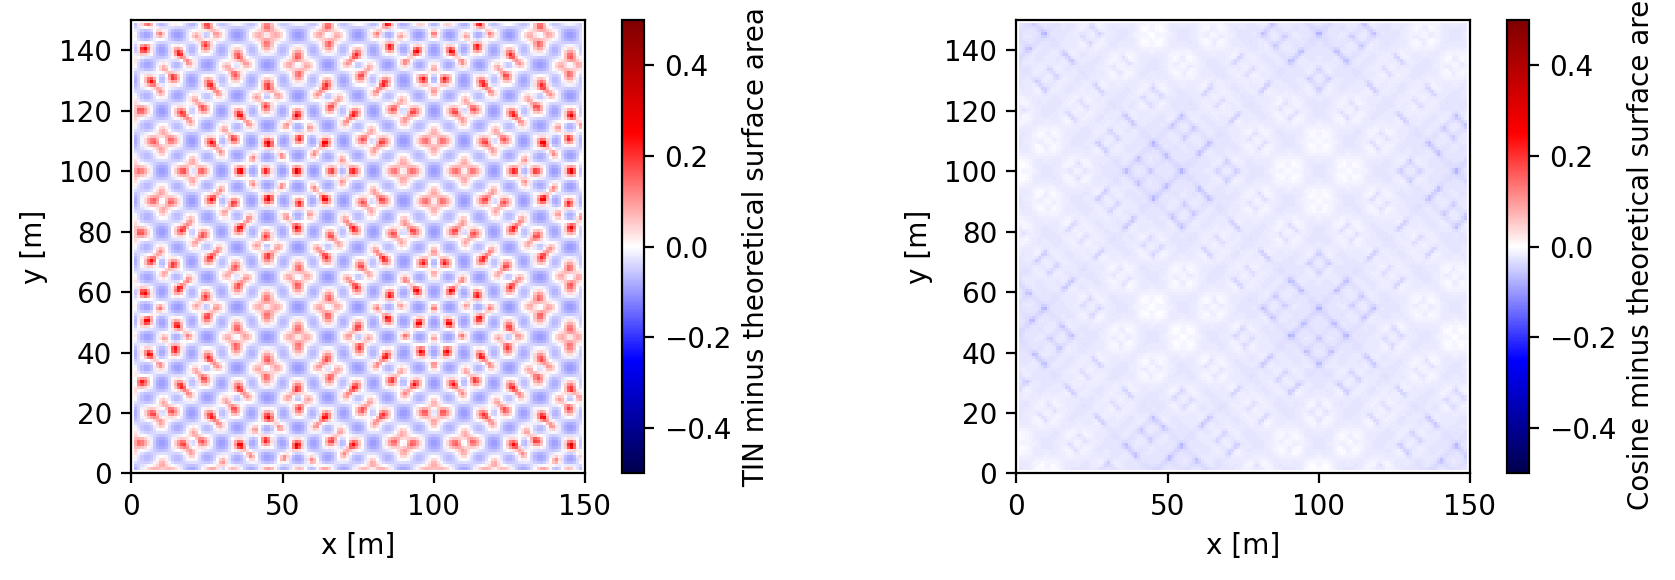

In [9]:
sa_num[0, :] = np.nan
sa_num[-1, :] = np.nan
sa_num[:, 0] = np.nan
sa_num[:, 0 - 1] = np.nan

fg, ax = pl.subplots(1, 2, figsize=(9, 3))
im = ax[0].pcolormesh(x, y, sa_tin - sa_num, vmin=-0.5, vmax=0.5, cmap="seismic")
ax[0].set_xlabel("x [m]")
ax[0].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[0])
cb.set_label("TIN minus theoretical surface area")
im = ax[1].pcolormesh(x, y, sa_cos - sa_num, vmin=-0.5, vmax=0.5, cmap="seismic")
ax[1].set_xlabel("x [m]")
ax[1].set_ylabel("y [m]")
cb = fg.colorbar(im, ax=ax[1])
cb.set_label("Cosine minus theoretical surface area")
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
pl.tight_layout()
pl.show()

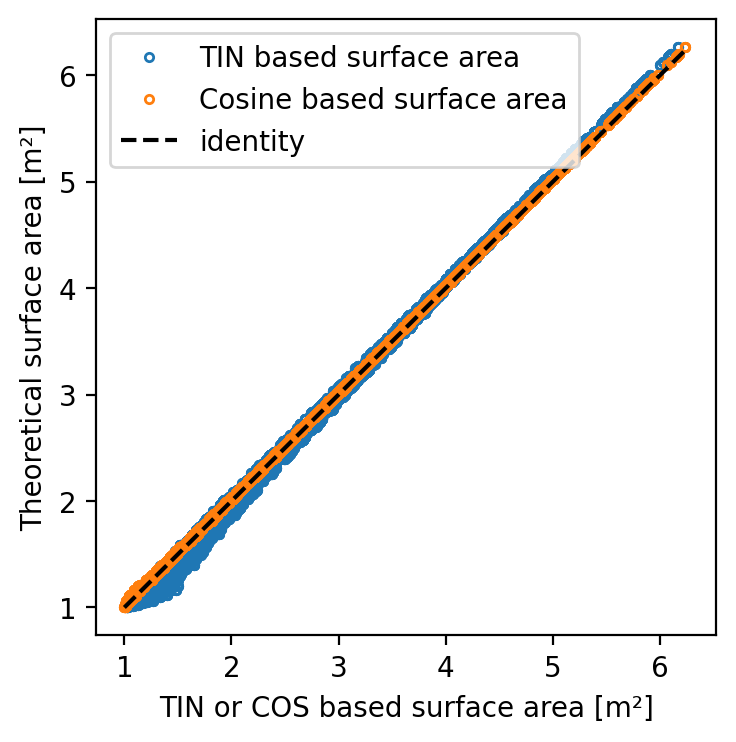

In [10]:
fg, ax = pl.subplots(figsize=(4, 4))
ax.plot(
    sa_tin[1:-1, 1:-1].ravel(),
    sa_num[1:-1, 1:-1].ravel(),
    ".",
    mfc="none",
    label="TIN based surface area",
)
ax.plot(
    sa_cos[1:-1, 1:-1].ravel(),
    sa_num[1:-1, 1:-1].ravel(),
    ".",
    mfc="none",
    label="Cosine based surface area",
)
ax.plot([1, np.nanmax(sa_num)], [1, np.nanmax(sa_num)], "k--", label="identity")
ax.set_xlabel("TIN or COS based surface area [m²]")
ax.set_ylabel("Theoretical surface area [m²]")
pl.legend()
pl.show()

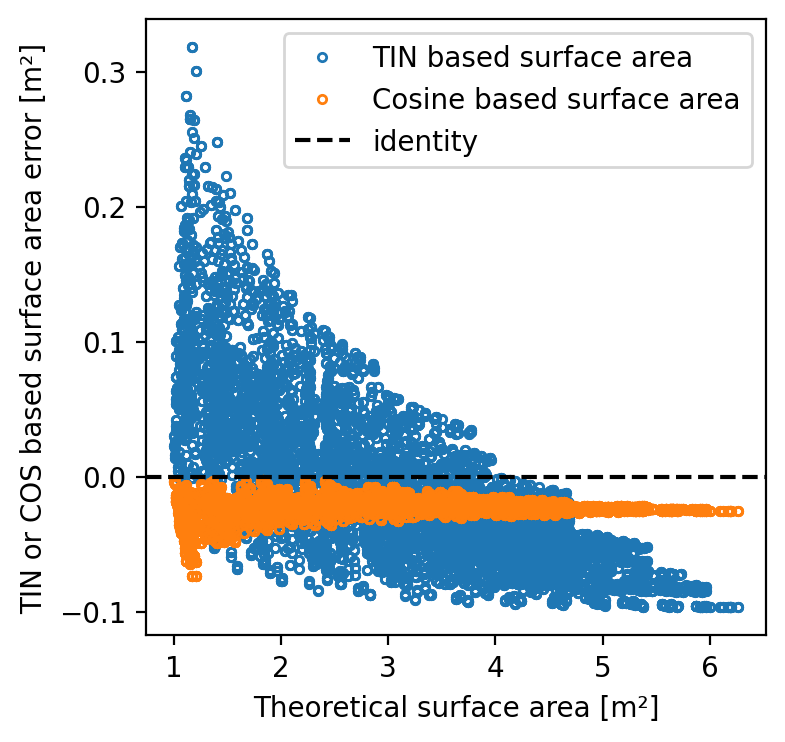

In [11]:
fg, ax = pl.subplots(figsize=(4, 4))
ax.plot(
    sa_num[1:-1, 1:-1].ravel(),
    sa_tin[1:-1, 1:-1].ravel() - sa_num[1:-1, 1:-1].ravel(),
    ".",
    mfc="none",
    label="TIN based surface area",
)
ax.plot(
    sa_num[1:-1, 1:-1].ravel(),
    sa_cos[1:-1, 1:-1].ravel() - sa_num[1:-1, 1:-1].ravel(),
    ".",
    mfc="none",
    label="Cosine based surface area",
)
ax.axhline(y=0, color="k", linestyle="--", label="identity")
ax.set_ylabel("TIN or COS based surface area error [m²]")
ax.set_xlabel("Theoretical surface area [m²]")
pl.legend()
pl.show()

In [5]:
resolutions = np.logspace(np.log10(0.2), np.log10(20), 20)
da_tin = np.zeros((len(resolutions), 4))
da_cos = np.zeros((len(resolutions), 4))
for i, resolution in enumerate(resolutions):
    print("step", i, ", resolution:", resolution)
    xr = np.arange(resolution/2, 150, resolution)
    yr = xr
    x, y = np.meshgrid(xr, yr)
    dtm = sa.synthetic_landscape(x, y, landscape_type="sincos", amplitude=100)
    x, y = x[1:-1, 1:-1], y[1:-1, 1:-1]
    sa_tin = sa.surface_area_tin(dtm, resolution)[1:-1, 1:-1].ravel()
    sa_cos = sa.surface_area_cos(dtm, resolution)[1:-1, 1:-1].ravel()
    sa_num = sa.synthetic_landscape_surface_area(x, y, landscape_type="sincos", amplitude=100).ravel()
    sa_tin_err = sa_tin - sa_num
    sa_cos_err = sa_cos - sa_num
    da_tin[i, 0] = np.abs(sa_tin_err).mean()
    da_tin[i, 1] = np.abs(sa_tin_err).std()
    da_tin[i, 2] = sa_tin_err.mean()
    da_tin[i, 3] = sa_tin_err.std()
    da_cos[i, 0] = np.abs(sa_cos_err).mean()
    da_cos[i, 1] = np.abs(sa_cos_err).std()
    da_cos[i, 2] = sa_cos_err.mean()
    da_cos[i, 3] = sa_cos_err.std()

step 0 , resolution: 0.2


100%|███████████████████████████████| 748/748 [37:33<00:00,  3.01s/it]


step 1 , resolution: 0.25485499714062676


100%|███████████████████████████████| 587/587 [21:35<00:00,  2.21s/it]


step 2 , resolution: 0.3247553478377444


100%|███████████████████████████████| 460/460 [12:51<00:00,  1.68s/it]


step 3 , resolution: 0.413827616222958


100%|███████████████████████████████| 360/360 [07:53<00:00,  1.31s/it]


step 4 , resolution: 0.5273301797460717


100%|███████████████████████████████| 282/282 [05:09<00:00,  1.10s/it]


step 5 , resolution: 0.6719636572567564


100%|███████████████████████████████| 221/221 [03:18<00:00,  1.11it/s]


step 6 , resolution: 0.8562664797438788


100%|███████████████████████████████| 173/173 [01:54<00:00,  1.52it/s]


step 7 , resolution: 1.0911189562337038


100%|███████████████████████████████| 135/135 [01:07<00:00,  2.00it/s]


step 8 , resolution: 1.3903855923551212


100%|███████████████████████████████| 106/106 [00:43<00:00,  2.43it/s]


step 9 , resolution: 1.7717335808201653


100%|█████████████████████████████████| 83/83 [00:27<00:00,  3.02it/s]


step 10 , resolution: 2.257675783369378


100%|█████████████████████████████████| 64/64 [00:14<00:00,  4.29it/s]


step 11 , resolution: 2.8768997765753266


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.76it/s]


step 12 , resolution: 3.6659614216648717


100%|█████████████████████████████████| 39/39 [00:05<00:00,  6.65it/s]


step 13 , resolution: 4.671442938180243


100%|█████████████████████████████████| 30/30 [00:05<00:00,  5.16it/s]


step 14 , resolution: 5.952702883262636


100%|█████████████████████████████████| 23/23 [00:05<00:00,  3.86it/s]


step 15 , resolution: 7.585380381464501


100%|█████████████████████████████████| 18/18 [00:06<00:00,  2.91it/s]


step 16 , resolution: 9.665860477143505


100%|█████████████████████████████████| 14/14 [00:07<00:00,  1.82it/s]


step 17 , resolution: 12.316964221320523


100%|█████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]


step 18 , resolution: 15.695199407029225


100%|███████████████████████████████████| 8/8 [00:08<00:00,  1.01s/it]


step 19 , resolution: 20.000000000000004


100%|███████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


In [6]:
np.savez("Surface_area_errors_sincos_landscape.npz", da_tin=da_tin, da_cos=da_cos)

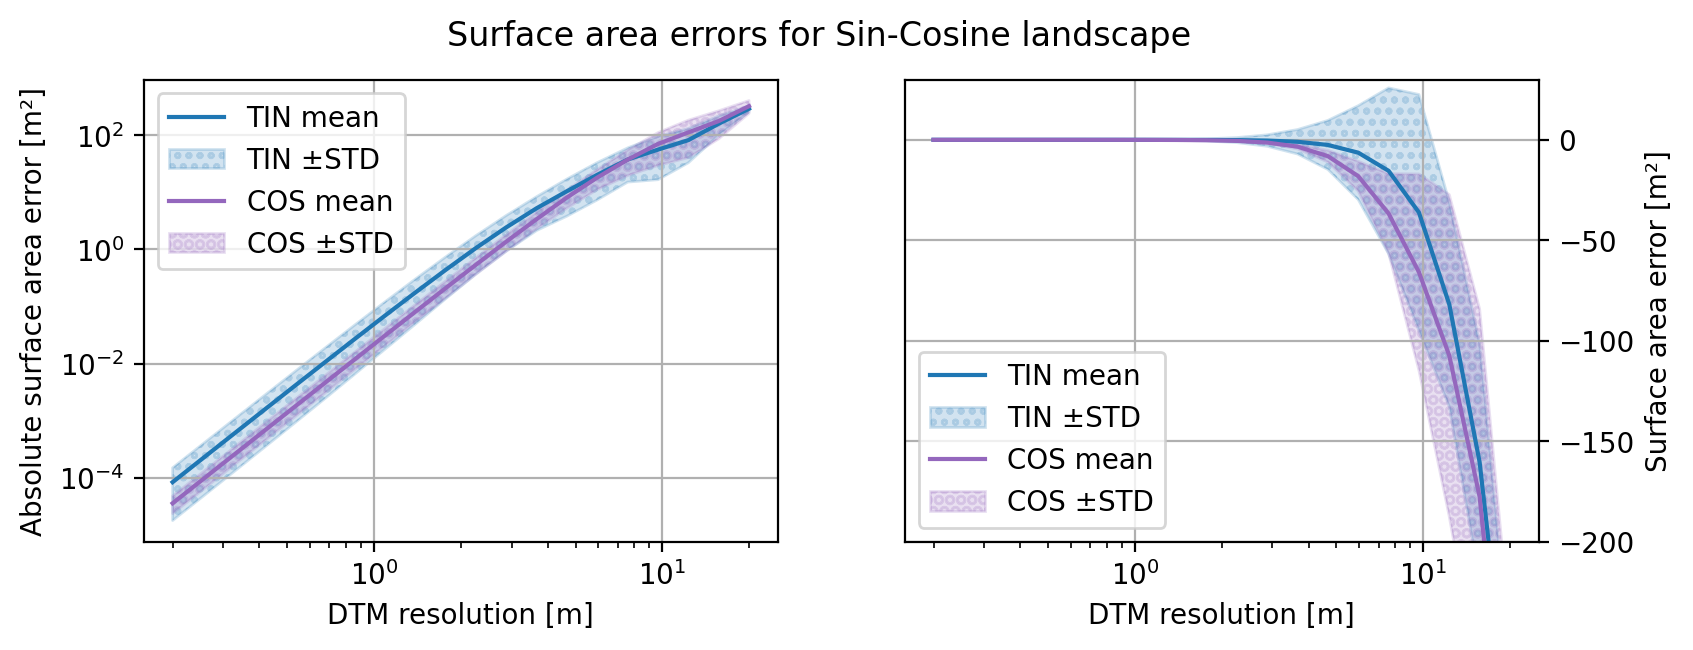

In [48]:
fp = np.load("Surface_area_errors_sincos_landscape.npz")
da_tin = fp["da_tin"]
da_cos = fp["da_cos"]
fg, ax = pl.subplots(1, 2, figsize=(9, 3))
fg.suptitle("Surface area errors for Sin-Cosine landscape")
for label, hatch, color, da in zip(("TIN", "COS"), (r"ooo", r"OOO"), ("tab:blue", "tab:purple"), (da_tin, da_cos)):
    ax[0].loglog(resolutions, da[:, 0], label=label+" mean", color=color)
    ax[0].fill_between(resolutions, da[:, 0] - da[:, 1], da[:, 0] + da[:, 1], color=color, alpha=0.2, hatch=hatch, label=label+" ±STD")
ax[0].set_xlabel("DTM resolution [m]")
ax[0].set_ylabel("Absolute surface area error [m²]")
ax[0].grid()
ax[0].legend()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
# ax[1].set_yscale('symlog', linthresh=1e-3)
ax[1].set_ylim((-200, 30))
for label, hatch, color, da in zip(("TIN", "COS"), (r"ooo", r"OOO"), ("tab:blue", "tab:purple"), (da_tin, da_cos)):
    ax[1].semilogx(resolutions, da[:, 2], label=label+" mean", color=color)
    ax[1].fill_between(resolutions, da[:, 2] - da[:, 3], da[:, 2] + da[:, 3], color=color, alpha=0.2, hatch=hatch, label=label+" ±STD")
ax[1].set_xlabel("DTM resolution [m]")
ax[1].set_ylabel("Surface area error [m²]")
ax[1].grid()
ax[1].legend()
pl.show()

In [49]:
resolutions = np.logspace(np.log10(0.2), np.log10(20), 20)
da_tin = np.zeros((len(resolutions), 4))
da_cos = np.zeros((len(resolutions), 4))
for i, resolution in enumerate(resolutions):
    print("step", i, ", resolution:", resolution)
    xr = np.arange(resolution/2, 150, resolution)
    yr = xr
    x, y = np.meshgrid(xr, yr)
    dtm = sa.synthetic_landscape(x, y, landscape_type="hill", amplitude=200)
    x, y = x[1:-1, 1:-1], y[1:-1, 1:-1]
    sa_tin = sa.surface_area_tin(dtm, resolution)[1:-1, 1:-1].ravel()
    sa_cos = sa.surface_area_cos(dtm, resolution)[1:-1, 1:-1].ravel()
    sa_num = sa.synthetic_landscape_surface_area(x, y, landscape_type="hill", amplitude=200).ravel()
    sa_tin_err = sa_tin - sa_num
    sa_cos_err = sa_cos - sa_num
    da_tin[i, 0] = np.abs(sa_tin_err).mean()
    da_tin[i, 1] = np.abs(sa_tin_err).std()
    da_tin[i, 2] = sa_tin_err.mean()
    da_tin[i, 3] = sa_tin_err.std()
    da_cos[i, 0] = np.abs(sa_cos_err).mean()
    da_cos[i, 1] = np.abs(sa_cos_err).std()
    da_cos[i, 2] = sa_cos_err.mean()
    da_cos[i, 3] = sa_cos_err.std()
    
np.savez("Surface_area_errors_hill_landscape.npz", da_tin=da_tin, da_cos=da_cos)

step 0 , resolution: 0.2


100%|███████████████████████████████| 748/748 [11:32<00:00,  1.08it/s]


step 1 , resolution: 0.25485499714062676


100%|███████████████████████████████| 587/587 [06:42<00:00,  1.46it/s]


step 2 , resolution: 0.3247553478377444


100%|███████████████████████████████| 460/460 [04:10<00:00,  1.84it/s]


step 3 , resolution: 0.413827616222958


100%|███████████████████████████████| 360/360 [02:34<00:00,  2.33it/s]


step 4 , resolution: 0.5273301797460717


100%|███████████████████████████████| 282/282 [01:32<00:00,  3.06it/s]


step 5 , resolution: 0.6719636572567564


100%|███████████████████████████████| 221/221 [00:56<00:00,  3.91it/s]


step 6 , resolution: 0.8562664797438788


100%|███████████████████████████████| 173/173 [00:34<00:00,  5.04it/s]


step 7 , resolution: 1.0911189562337038


100%|███████████████████████████████| 135/135 [00:21<00:00,  6.43it/s]


step 8 , resolution: 1.3903855923551212


100%|███████████████████████████████| 106/106 [00:12<00:00,  8.53it/s]


step 9 , resolution: 1.7717335808201653


100%|█████████████████████████████████| 83/83 [00:08<00:00,  9.73it/s]


step 10 , resolution: 2.257675783369378


100%|█████████████████████████████████| 64/64 [00:03<00:00, 16.84it/s]


step 11 , resolution: 2.8768997765753266


100%|█████████████████████████████████| 50/50 [00:04<00:00, 12.29it/s]


step 12 , resolution: 3.6659614216648717


100%|█████████████████████████████████| 39/39 [00:01<00:00, 34.50it/s]


step 13 , resolution: 4.671442938180243


100%|█████████████████████████████████| 30/30 [00:00<00:00, 46.06it/s]


step 14 , resolution: 5.952702883262636


100%|█████████████████████████████████| 23/23 [00:00<00:00, 53.77it/s]


step 15 , resolution: 7.585380381464501


100%|█████████████████████████████████| 18/18 [00:00<00:00, 52.34it/s]


step 16 , resolution: 9.665860477143505


100%|█████████████████████████████████| 14/14 [00:00<00:00, 58.09it/s]


step 17 , resolution: 12.316964221320523


100%|█████████████████████████████████| 10/10 [00:00<00:00, 75.71it/s]


step 18 , resolution: 15.695199407029225


100%|███████████████████████████████████| 8/8 [00:00<00:00, 91.64it/s]


step 19 , resolution: 20.000000000000004


100%|██████████████████████████████████| 5/5 [00:00<00:00, 137.16it/s]


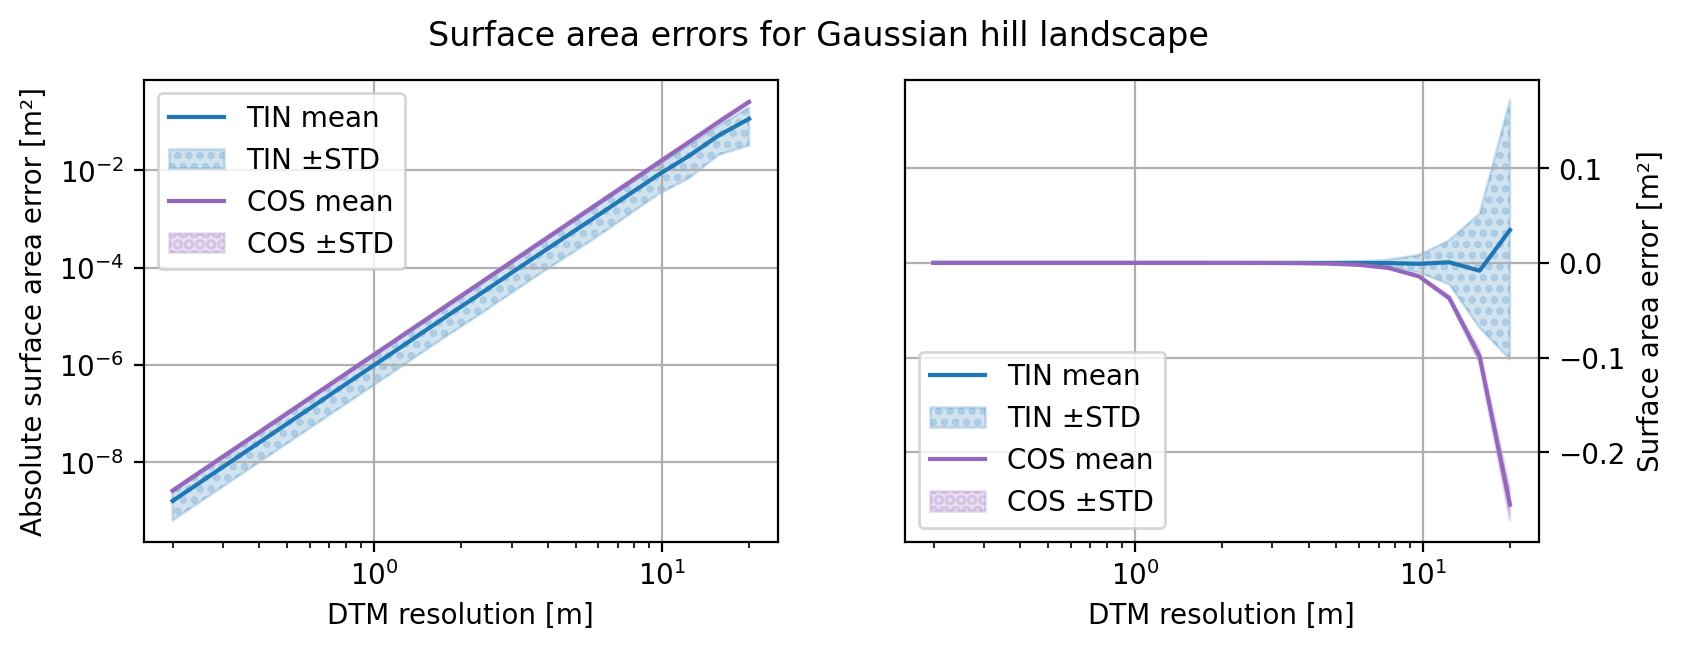

In [50]:
fp = np.load("Surface_area_errors_hill_landscape.npz")
da_tin = fp["da_tin"]
da_cos = fp["da_cos"]
fg, ax = pl.subplots(1, 2, figsize=(9, 3))
fg.suptitle("Surface area errors for Gaussian hill landscape")
for label, hatch, color, da in zip(("TIN", "COS"), (r"ooo", r"OOO"), ("tab:blue", "tab:purple"), (da_tin, da_cos)):
    ax[0].loglog(resolutions, da[:, 0], label=label+" mean", color=color)
    ax[0].fill_between(resolutions, da[:, 0] - da[:, 1], da[:, 0] + da[:, 1], color=color, alpha=0.2, hatch=hatch, label=label+" ±STD")
ax[0].set_xlabel("DTM resolution [m]")
ax[0].set_ylabel("Absolute surface area error [m²]")
ax[0].grid()
ax[0].legend()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
# ax[1].set_yscale('symlog', linthresh=1e-3)
# ax[1].set_ylim((-200, 30))
for label, hatch, color, da in zip(("TIN", "COS"), (r"ooo", r"OOO"), ("tab:blue", "tab:purple"), (da_tin, da_cos)):
    ax[1].semilogx(resolutions, da[:, 2], label=label+" mean", color=color)
    ax[1].fill_between(resolutions, da[:, 2] - da[:, 3], da[:, 2] + da[:, 3], color=color, alpha=0.2, hatch=hatch, label=label+" ±STD")
ax[1].set_xlabel("DTM resolution [m]")
ax[1].set_ylabel("Surface area error [m²]")
ax[1].grid()
ax[1].legend()
pl.show()